In [ ]:
import pandas as pd
import numpy as np
import matplotlib as plt

In [ ]:

# Load the training and testing data
train_df = pd.read_parquet("UNSW_NB15_training-set.parquet")
test_df = pd.read_parquet("UNSW_NB15_testing-set.parquet")

# Combine them into one DataFrame
df = pd.concat([train_df, test_df], ignore_index=True)

# Preview the data
df.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sload,...,trans_depth,response_body_len,ct_src_dport_ltm,ct_dst_sport_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,is_sm_ips_ports,attack_cat,label
0,0.121478,tcp,-,FIN,6,4,258,172,74.087486,14158.942383,...,0,0,1,1,0,0,0,0,Normal,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473373,8395.112305,...,0,0,1,1,0,0,0,0,Normal,0
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,1572.271851,...,0,0,1,1,0,0,0,0,Normal,0
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,2740.178955,...,0,0,1,1,1,1,0,0,Normal,0
4,0.449454,tcp,-,FIN,10,6,534,268,33.373825,8561.499023,...,0,0,2,1,0,0,0,0,Normal,0


In [ ]:
# 🔍 Step 3: Data Cleaning (Fixed version)

# View the available columns first (just to cross-check)
print("Columns in dataset:\n", df.columns)

# No need to drop 'srcip' or 'dstip' since they're not present
# Check and drop missing values
print("\nMissing values:\n", df.isnull().sum())

df.dropna(inplace=True)

# Identify categorical columns (like 'proto', 'service', etc.)
cat_cols = df.select_dtypes(include='object').columns
print("\nCategorical columns:\n", cat_cols)

# Convert all categorical columns to string (just in case)
df[cat_cols] = df[cat_cols].astype(str)

# One-hot encode the categorical columns
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Separate features and target
X = df_encoded.drop(columns=['label'])  # target column is 'label'
y = df_encoded['label']

# Final shapes
print("\nFeature shape:", X.shape)
print(" Label shape:", y.shape)


Columns in dataset:
 Index(['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt',
       'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt',
       'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'is_sm_ips_ports',
       'attack_cat', 'label'],
      dtype='object')

Missing values:
 dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tc

In [ ]:
import pandas as pd
import numpy as np

# Make a copy of the original dataset
df = train_df.copy()

# Step 1: Check how many '-' values exist
print("Step 1 - Before replacing '-':")
print((df == '-').sum())

# Step 2: Replace '-' with NaN
df.replace('-', np.nan, inplace=True)

# Step 3: Check NaN counts
print("\nStep 2 - After replacing '-':")
print(df.isna().sum())

# Step 4: Convert all except label columns
numeric_cols = [col for col in df.columns if col not in ['proto', 'state', 'label', 'attack_cat']]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Step 5: Drop only a few crucial NaNs for now
crucial_cols = ['dur', 'sbytes', 'dbytes', 'rate']
print("\nStep 3 - NaNs in crucial columns:")
print(df[crucial_cols].isna().sum())

df.dropna(subset=crucial_cols, inplace=True)

# Step 6: Show final shape
print("\n Final shape after preprocessing:", df.shape)


Step 1 - Before replacing '-':
dur                      0
proto                    0
service              94168
state                    0
spkts                    0
dpkts                    0
sbytes                   0
dbytes                   0
rate                     0
sload                    0
dload                    0
sloss                    0
dloss                    0
sinpkt                   0
dinpkt                   0
sjit                     0
djit                     0
swin                     0
stcpb                    0
dtcpb                    0
dwin                     0
tcprtt                   0
synack                   0
ackdat                   0
smean                    0
dmean                    0
trans_depth              0
response_body_len        0
ct_src_dport_ltm         0
ct_dst_sport_ltm         0
is_ftp_login             0
ct_ftp_cmd               0
ct_flw_http_mthd         0
is_sm_ips_ports          0
attack_cat               0
label                   

<ipython-input-4-9f9fe0511427>:12: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df.replace('-', np.nan, inplace=True)


In [ ]:
def preprocess(df):
      df = df.copy()

      # Convert all columns (except categorical ones) to numeric, forcing errors to NaN
      for col in df.columns:
          if col not in ['proto', 'state', 'label', 'attack_cat']:
              df[col] = pd.to_numeric(df[col], errors='coerce')

      # Drop columns that became fully NaN after conversion (i.e., garbage columns)
      null_cols = df.columns[df.isna().all()]
      if len(null_cols):
          print(f" Dropping fully null columns: {list(null_cols)}")
      df.drop(columns=null_cols, inplace=True)

      # Drop rows that have NaN in crucial numeric fields only
      df.dropna(subset=['dur', 'sbytes', 'dbytes', 'rate'], inplace=True)

      # Convert categorical columns to string
      cat_cols = ['proto', 'state']
      df[cat_cols] = df[cat_cols].astype(str)

      # One-hot encode categorical columns
      df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

      return df

train_df_clean = preprocess(train_df)
test_df_clean = preprocess(test_df)

  # Align columns of test to match train
train_labels = train_df_clean['label']
test_labels = test_df_clean['label']

train_df_clean = train_df_clean.drop(columns=['label'])
test_df_clean = test_df_clean.drop(columns=['label'])

  # Align test to have same columns as train
test_df_clean = test_df_clean.reindex(columns=train_df_clean.columns, fill_value=0)

print("Train Features Shape:", train_df_clean.shape)
print("Test Features Shape:", test_df_clean.shape)



 Dropping fully null columns: ['service']
 Dropping fully null columns: ['service']
Train Features Shape: (175341, 172)
Test Features Shape: (82332, 172)


In [ ]:
# After preprocess step
print("\n🧹 Checking columns after preprocessing:")

non_numeric_cols = [col for col in train_df_clean.columns if train_df_clean[col].dtype not in [np.float64, np.int64, np.int32, np.float32]]
print(" Non-numeric columns found:", non_numeric_cols)

# Drop the non-numeric columns
train_df_clean.drop(columns=non_numeric_cols, inplace=True)
test_df_clean.drop(columns=non_numeric_cols, inplace=True)

print(" Cleaned dataset shapes:", train_df_clean.shape, test_df_clean.shape)
train_df_clean.columns
test_df_clean.columns


🧹 Checking columns after preprocessing:
 Non-numeric columns found: ['spkts', 'dpkts', 'sloss', 'dloss', 'swin', 'dwin', 'smean', 'dmean', 'trans_depth', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'is_sm_ips_ports', 'attack_cat', 'proto_a/n', 'proto_aes-sp3-d', 'proto_any', 'proto_argus', 'proto_aris', 'proto_arp', 'proto_ax.25', 'proto_bbn-rcc', 'proto_bna', 'proto_br-sat-mon', 'proto_cbt', 'proto_cftp', 'proto_chaos', 'proto_compaq-peer', 'proto_cphb', 'proto_cpnx', 'proto_crtp', 'proto_crudp', 'proto_dcn', 'proto_ddp', 'proto_ddx', 'proto_dgp', 'proto_egp', 'proto_eigrp', 'proto_emcon', 'proto_encap', 'proto_etherip', 'proto_fc', 'proto_fire', 'proto_ggp', 'proto_gmtp', 'proto_gre', 'proto_hmp', 'proto_i-nlsp', 'proto_iatp', 'proto_ib', 'proto_icmp', 'proto_idpr', 'proto_idpr-cmtp', 'proto_idrp', 'proto_ifmp', 'proto_igmp', 'proto_igp', 'proto_il', 'proto_ip', 'proto_ipcomp', 'proto_ipcv', 'proto_ipip', 'proto_iplt', 'proto_ipnip', 'pr

Index(['dur', 'sbytes', 'dbytes', 'rate', 'sload', 'dload', 'sinpkt', 'dinpkt',
       'sjit', 'djit', 'stcpb', 'dtcpb', 'tcprtt', 'synack', 'ackdat',
       'response_body_len'],
      dtype='object')

In [ ]:
# Feature Engineering based only on available columns

train_df_clean['bytes_ratio'] = (train_df_clean['sbytes'] + 1) / (train_df_clean['dbytes'] + 1)
train_df_clean['load_ratio'] = (train_df_clean['sload'] + 1) / (train_df_clean['dload'] + 1)
train_df_clean['pkt_time_ratio'] = (train_df_clean['sinpkt'] + 1) / (train_df_clean['dinpkt'] + 1)
train_df_clean['jit_ratio'] = (train_df_clean['sjit'] + 1) / (train_df_clean['djit'] + 1)

test_df_clean['bytes_ratio'] = (test_df_clean['sbytes'] + 1) / (test_df_clean['dbytes'] + 1)
test_df_clean['load_ratio'] = (test_df_clean['sload'] + 1) / (test_df_clean['dload'] + 1)
test_df_clean['pkt_time_ratio'] = (test_df_clean['sinpkt'] + 1) / (test_df_clean['dinpkt'] + 1)
test_df_clean['jit_ratio'] = (test_df_clean['sjit'] + 1) / (test_df_clean['djit'] + 1)


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. Split the data again if needed (Train + Validation)
X_train_new, X_val, y_train_new, y_val = train_test_split(
    train_df_clean, train_labels, test_size=0.1, random_state=42
)

# 2. Create the strong-tuned LGBM model
lgbm_model = lgb.LGBMClassifier(
    n_estimators=1500,          # More trees for better learning
    learning_rate=0.015,        # Smaller steps
    num_leaves=80,              # Slightly bigger tree width
    max_depth=9,                # Deeper trees
    subsample=0.85,             # Take 85% of data randomly per tree
    colsample_bytree=0.85,      # Take 85% of features randomly per tree
    reg_alpha=0.1,              # L1 regularization (sparse features)
    reg_lambda=0.2,             # L2 regularization (shrinkage)
    class_weight='balanced',    # Because your data is imbalanced (likely)
    random_state=42,
    n_jobs=-1,                  # Use all CPU cores
    verbosity=-1                # Hide training logs (optional)
)

# 3. Train with early stopping
lgbm_model.fit(
    X_train_new, y_train_new,
    eval_set=[(X_val, y_val)],
    eval_metric='logloss',
    callbacks=[lgb.early_stopping(stopping_rounds=50)]  # Wait 50 rounds
)

#  4. Predict on the test set
y_pred = lgbm_model.predict(test_df_clean)

#  5. Evaluate
acc = accuracy_score(test_labels, y_pred)
cm = confusion_matrix(test_labels, y_pred)
report = classification_report(test_labels, y_pred)

print(f" Test Accuracy: {acc:.4f}")
print("\n Confusion Matrix:")
print(cm)
print("\n Classification Report:")
print(report)



Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1500]	valid_0's binary_logloss: 0.117259
 Test Accuracy: 0.8917

 Confusion Matrix:
[[30345  6655]
 [ 2263 43069]]

 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.82      0.87     37000
           1       0.87      0.95      0.91     45332

    accuracy                           0.89     82332
   macro avg       0.90      0.89      0.89     82332
weighted avg       0.90      0.89      0.89     82332



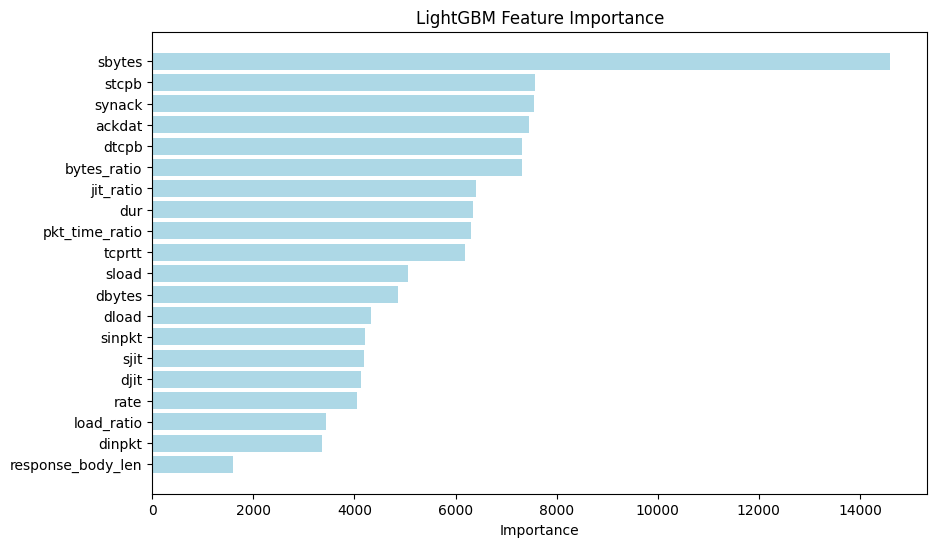

In [ ]:
import matplotlib.pyplot as plt

importance = lgbm_model.feature_importances_

features = X_train_new.columns  # Assuming you've used a DataFrame for your features
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importance
})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='lightblue')
plt.xlabel('Importance')
plt.title('LightGBM Feature Importance')
plt.gca().invert_yaxis()  # Invert Y-axis for better readability
plt.show()


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. Define proper features by the above graph
features_to_keep = [
    'sbytes', 'stcpb', 'synack', 'ackdat', 'dtcpb',
    'bytes_ratio', 'jit_ratio', 'dur', 'pkt_time_ratio',
    'tcprtt', 'sload', 'dbytes', 'dload', 'sinpkt',
    'sjit', 'djit', 'rate', 'load_ratio', 'dinpkt',
    'response_body_len'
]

# 2. Prepare correct data
X = train_df_clean[features_to_keep]
y = train_labels

# 3. Split again
X_train_new, X_val, y_train_new, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42
)

# 4. Create strong tuned model
lgbm_model = lgb.LGBMClassifier(
    n_estimators=1500,
    learning_rate=0.015,
    num_leaves=80,
    max_depth=9,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_alpha=0.1,
    reg_lambda=0.2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)

# 5. Fit the model
lgbm_model.fit(X_train_new, y_train_new)

# 6. Predict and Evaluate
y_pred_val = lgbm_model.predict(X_val)

print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))
print(confusion_matrix(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))

import joblib

# Save the model
joblib.dump(lgbm_model, 'anomaly_detection_models_binary.joblib')

Validation Accuracy: 0.9421727972626176
[[ 5213   397]
 [  617 11308]]
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      5610
           1       0.97      0.95      0.96     11925

    accuracy                           0.94     17535
   macro avg       0.93      0.94      0.93     17535
weighted avg       0.94      0.94      0.94     17535



['anomaly_detection_models_binary.joblib']

In [ ]:
# 1. Predict and evaluate the model on the validation set
y_pred_val = lgbm_model.predict(X_val)

# 2. Print the accuracy and other evaluation metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print(f"Validation Accuracy: {accuracy_score(y_val, y_pred_val):.4f}")
print(confusion_matrix(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))


Validation Accuracy: 0.9422
[[ 5213   397]
 [  617 11308]]
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      5610
           1       0.97      0.95      0.96     11925

    accuracy                           0.94     17535
   macro avg       0.93      0.94      0.93     17535
weighted avg       0.94      0.94      0.94     17535



In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# 1. Define your final features
features_to_keep = [
    'sbytes', 'stcpb', 'synack', 'ackdat', 'dtcpb',
    'bytes_ratio', 'jit_ratio', 'dur', 'pkt_time_ratio',
    'tcprtt', 'sload', 'dbytes', 'dload', 'sinpkt',
    'sjit', 'djit', 'rate', 'load_ratio', 'dinpkt',
    'response_body_len'
]

# 2. Features and Multi-Class Label ('attack_cat', including 'Normal')
X = train_df_clean[features_to_keep]
# Add interaction features
X['sbytes_stcpb'] = X['sbytes'] * X['stcpb']
X['synack_ackdat'] = X['synack'] + X['ackdat']
features_to_keep.extend(['sbytes_stcpb', 'synack_ackdat'])
X = X[features_to_keep]

le = LabelEncoder()
y = le.fit_transform(train_df['attack_cat'])   # This includes 'Normal' as a class


# 3. Train/Validation Split
X_train_new, X_val, y_train_new, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train_new, y_train_new)


# 4. Create and train the LGBM model
lgbm_model = lgb.LGBMClassifier(
    n_estimators=1500,
    learning_rate=0.015,
    num_leaves=80,
    max_depth=9,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_alpha=0.1,
    reg_lambda=0.2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbosity=-1
)

lgbm_model.fit(X_resampled, y_resampled)

# 5. Predict and Evaluate
y_pred_val = lgbm_model.predict(X_val)
predicted_labels = le.inverse_transform(y_pred_val)

print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))
print(confusion_matrix(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))

import joblib

# Save the model
joblib.dump(lgbm_model, 'anomaly_detection_models_multiclass.joblib')

<ipython-input-16-4d8f37bdf6d3>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['sbytes_stcpb'] = X['sbytes'] * X['stcpb']
<ipython-input-16-4d8f37bdf6d3>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['synack_ackdat'] = X['synack'] + X['ackdat']


Validation Accuracy: 0.7555175363558597
[[  40   97   49    4    2    0    8    0    0    0]
 [   1   91   58   18    3    0    0    2    2    0]
 [  19  584  394  159   34    4    8    6   13    5]
 [  37  757  549 1733  117    2   26   76   30   13]
 [   4   72   61   38 1401    1  133   14   89    6]
 [   1   18   14   38    6 3917    1    1    4    0]
 [  36    1    3   67  571    0 4834   29   57    2]
 [   0  107   71   66   11    0    4  771   19    0]
 [   1    3    2    6   27    2    1   10   61    0]
 [   0    0    0    5    2    0    0    0    0    6]]
              precision    recall  f1-score   support

           0       0.29      0.20      0.24       200
           1       0.05      0.52      0.10       175
           2       0.33      0.32      0.32      1226
           3       0.81      0.52      0.63      3340
           4       0.64      0.77      0.70      1819
           5       1.00      0.98      0.99      4000
           6       0.96      0.86      0.91      5

['anomaly_detection_models_multiclass.joblib']

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Step 1: Use the same features
features_to_keep = [
    'sbytes', 'stcpb', 'synack', 'ackdat', 'dtcpb',
    'bytes_ratio', 'jit_ratio', 'dur', 'pkt_time_ratio',
    'tcprtt', 'sload', 'dbytes', 'dload', 'sinpkt',
    'sjit', 'djit', 'rate', 'load_ratio', 'dinpkt',
    'response_body_len'
]

X_full = train_df_clean[features_to_keep]

# Step 2: Filter only Normal traffic
X_normal = train_df_clean[train_df['attack_cat'] == 'Normal'][features_to_keep]

# Step 3: Train Isolation Forest on Normal data
iso_model = IsolationForest(
    n_estimators=200,
    contamination=0.01,  # tweak depending on how sensitive you want detection
    max_samples='auto',
    random_state=42,
    n_jobs=-1,
    verbose=0
)

iso_model.fit(X_normal)

# Step 4: Predict on the entire dataset
iso_preds = iso_model.predict(X_full)

# Convert to 0 = normal, 1 = anomaly (sklearn gives -1 for anomaly)
iso_preds = np.where(iso_preds == -1, 1, 0)

# Create true anomaly labels (1 for any attack, 0 for Normal)
true_anomalies = np.where(train_df['attack_cat'] != 'Normal', 1, 0)

# Step 5: Evaluation
print("Isolation Forest Performance on Full Data:")
print(confusion_matrix(true_anomalies, iso_preds))
print(classification_report(true_anomalies, iso_preds))


Isolation Forest Performance on Full Data:
[[ 55441    559]
 [118046   1295]]
              precision    recall  f1-score   support

           0       0.32      0.99      0.48     56000
           1       0.70      0.01      0.02    119341

    accuracy                           0.32    175341
   macro avg       0.51      0.50      0.25    175341
weighted avg       0.58      0.32      0.17    175341

